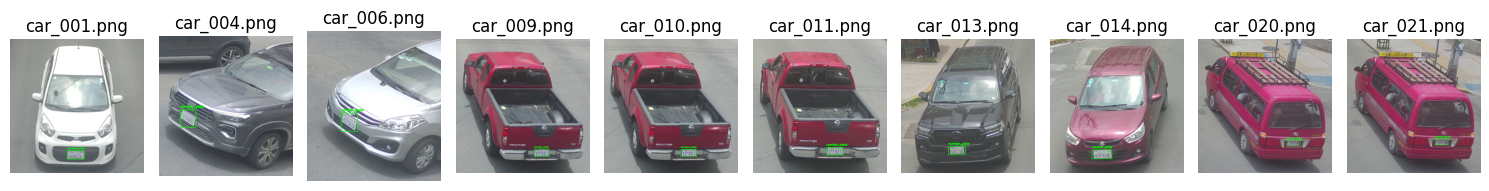

In [2]:
import os
import cv2
import matplotlib.pyplot as plt

# Directorios
imagenes_dir = "dataset_yolo/images/"  # Carpeta donde están las imágenes
anotaciones_dir = "dataset_yolo/labels/"  # Carpeta donde están las anotaciones YOLO
clases = ["number_plate"]  # Reemplaza con tus clases definidas

# Función para leer las anotaciones YOLO
def leer_anotaciones_yolo(txt_path, img_width, img_height):
    boxes = []
    with open(txt_path, "r") as file:
        for line in file:
            elementos = line.strip().split()
            clase_id = int(elementos[0])
            x_centro = float(elementos[1]) * img_width
            y_centro = float(elementos[2]) * img_height
            ancho = float(elementos[3]) * img_width
            alto = float(elementos[4]) * img_height

            # Convertir a formato (xmin, ymin, xmax, ymax)
            xmin = int(x_centro - ancho / 2)
            ymin = int(y_centro - alto / 2)
            xmax = int(x_centro + ancho / 2)
            ymax = int(y_centro + alto / 2)

            boxes.append((xmin, ymin, xmax, ymax, clase_id))
    return boxes

# Función para mostrar imágenes con anotaciones
def mostrar_lote(imagenes_dir, anotaciones_dir, clases, num_lote=5):
    imagenes = [f for f in os.listdir(imagenes_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
    plt.figure(figsize=(15, 15))

    for i, imagen_nombre in enumerate(imagenes[:num_lote]):
        img_path = os.path.join(imagenes_dir, imagen_nombre)
        txt_path = os.path.join(anotaciones_dir, os.path.splitext(imagen_nombre)[0] + ".txt")

        # Leer imagen
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_height, img_width, _ = img.shape

        # Leer anotaciones
        boxes = leer_anotaciones_yolo(txt_path, img_width, img_height)

        # Dibujar las cajas delimitadoras
        for box in boxes:
            xmin, ymin, xmax, ymax, clase_id = box
            color = (0, 255, 0)  # Color de las cajas
            img = cv2.rectangle(img, (xmin, ymin), (xmax, ymax), color, 2)
            img = cv2.putText(img, clases[clase_id], (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        # Mostrar la imagen en el lote
        plt.subplot(1, num_lote, i + 1)
        plt.imshow(img)
        plt.title(imagen_nombre)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Mostrar un lote de imágenes con sus anotaciones
mostrar_lote(imagenes_dir, anotaciones_dir, clases, num_lote=10)


In [5]:
import os
import random
import shutil

# Directorios de entrada y salida
images_folder = './dataset_yolo/images/'
annotations_folder = './dataset_yolo/labels/'
train_folder = './yolov11/data_images/train'
val_folder = './yolov11/data_images/validation'

# Crear directorios de salida si no existen
os.makedirs(os.path.join(train_folder, 'images'), exist_ok=True)
os.makedirs(os.path.join(train_folder, 'labels'), exist_ok=True)
os.makedirs(os.path.join(val_folder, 'images'), exist_ok=True)
os.makedirs(os.path.join(val_folder, 'labels'), exist_ok=True)

# Obtener las imágenes disponibles
image_files = [f for f in os.listdir(images_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Mezclar y dividir las imágenes
random.shuffle(image_files)
train_size = int(0.8 * len(image_files))
train_files = image_files[:train_size]
val_files = image_files[train_size:]

# Función para copiar archivos

def copy_files(file_list, dest_images, dest_labels):
    for image_file in file_list:
        # Copiar la imagen
        src_image_path = os.path.join(images_folder, image_file)
        dest_image_path = os.path.join(dest_images, image_file)
        shutil.copy(src_image_path, dest_image_path)

        # Copiar la anotación correspondiente
        annotation_file = os.path.splitext(image_file)[0] + '.txt'
        src_annotation_path = os.path.join(annotations_folder, annotation_file)
        if os.path.exists(src_annotation_path):
            dest_annotation_path = os.path.join(dest_labels, annotation_file)
            shutil.copy(src_annotation_path, dest_annotation_path)

# Copiar archivos de entrenamiento
copy_files(train_files, os.path.join(train_folder, 'images'), os.path.join(train_folder, 'labels'))

# Copiar archivos de validación
copy_files(val_files, os.path.join(val_folder, 'images'), os.path.join(val_folder, 'labels'))

# Crear archivo YAML para YOLO
yaml_content = f"""# Rutas a las imágenes y anotaciones
train: {os.path.abspath(train_folder).replace('\\', '/')}
val: {os.path.abspath(val_folder).replace('\\', '/')}

# Número de clases
nc: 1  # Cambia a la cantidad de clases que tienes en tu dataset

# Nombres de las clases
names: ['license_plate']  # Lista de nombres de clases
"""

with open('./yolov11/dataset.yaml', 'w') as yaml_file:
    yaml_file.write(yaml_content)

print(f"Se dividió el conjunto de datos en {len(train_files)} para entrenamiento y {len(val_files)} para validación.")


Se dividió el conjunto de datos en 1014 para entrenamiento y 254 para validación.


In [1]:
import torch

# Liberar toda la memoria de la GPU
torch.cuda.empty_cache()


In [6]:
from ultralytics import YOLO

# Cargar modelo YOLOv11
model = YOLO('yolo11l.pt')

# Entrenar el modelo
model.train(
    data='yolov11/dataset.yaml',  # Ruta al archivo YAML de tus datos
    epochs=100,                # Número de épocas
    batch=12,                  # Tamaño del lote (El modelo pre entrenado es pesado y con el tamano de lote podemos ajustar la cantidad de VRAM usada en cada epoch)
    patience=10,               # Early stopping si no mejora en 10 épocas
    name='YOLOv11_plates'      # Nombre del experimento
)


Ultralytics 8.3.59  Python-3.12.8 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4080 Laptop GPU, 12282MiB)
engine\trainer: task=detect, mode=train, model=yolo11l.pt, data=yolov11/dataset.yaml, epochs=100, time=None, patience=10, batch=12, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=YOLOv11_plates2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True

train: Scanning C:\Users\ALIENWARE M16 R1\Documents\Projects\Python\ANPR\yolov11\data_images\train\labels.cache... 1014 images, 4 backgrounds, 0 corrupt: 100%|██████████| 1014/1014 [00:00<?, ?it/s]
val: Scanning C:\Users\ALIENWARE M16 R1\Documents\Projects\Python\ANPR\yolov11\data_images\validation\labels.cache... 254 images, 5 backgrounds, 0 corrupt: 100%|██████████| 254/254 [00:00<?, ?it/s]


Plotting labels to runs\detect\YOLOv11_plates2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.00046875), 173 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\YOLOv11_plates2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      8.28G      1.206      1.464      1.144          6        640: 100%|██████████| 85/85 [00:22<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.79it/s]

                   all        254        257    0.00733      0.712    0.00616    0.00384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      8.37G      1.231     0.8474      1.148          5        640: 100%|██████████| 85/85 [00:20<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.91it/s]

                   all        254        257    0.00296      0.175    0.00114   0.000564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      8.34G      1.296       0.97      1.164          8        640: 100%|██████████| 85/85 [00:20<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.95it/s]

                   all        254        257      0.807       0.56      0.596       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      8.34G      1.248     0.8699      1.158          7        640: 100%|██████████| 85/85 [00:20<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.04it/s]

                   all        254        257      0.796      0.471      0.536      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      8.34G      1.206      1.832       1.11          8        640: 100%|██████████| 85/85 [00:20<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.74it/s]

                   all        254        257      0.639      0.751      0.574      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      8.34G      1.187     0.7741      1.118          8        640: 100%|██████████| 85/85 [00:20<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.79it/s]

                   all        254        257      0.447      0.249      0.249      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      8.34G      1.177     0.7152      1.105          9        640: 100%|██████████| 85/85 [00:21<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.05it/s]

                   all        254        257      0.894      0.883      0.914      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      8.39G      1.142     0.6953      1.095          9        640: 100%|██████████| 85/85 [00:20<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.78it/s]

                   all        254        257      0.949      0.934      0.952      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      8.34G      1.121     0.6493      1.074          7        640: 100%|██████████| 85/85 [00:20<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.70it/s]

                   all        254        257      0.905      0.907      0.936      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      8.34G      1.112     0.6331      1.072          8        640: 100%|██████████| 85/85 [00:20<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.81it/s]

                   all        254        257      0.927      0.895      0.928      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      8.34G       1.12     0.6316      1.068         10        640: 100%|██████████| 85/85 [00:20<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.99it/s]

                   all        254        257      0.932      0.887      0.933       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      8.34G      1.107     0.6077      1.064         13        640: 100%|██████████| 85/85 [00:20<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.72it/s]

                   all        254        257      0.935      0.899       0.94      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      8.34G      1.107      0.606      1.066         13        640: 100%|██████████| 85/85 [00:20<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.94it/s]

                   all        254        257      0.948      0.919      0.958       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      8.33G      1.092     0.5897      1.056          9        640: 100%|██████████| 85/85 [00:20<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.89it/s]

                   all        254        257      0.883      0.856        0.9      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      8.34G      1.069     0.6054      1.055          5        640: 100%|██████████| 85/85 [00:20<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.93it/s]

                   all        254        257      0.946      0.934       0.96      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      8.34G       1.08     0.5747      1.057         11        640: 100%|██████████| 85/85 [00:20<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.82it/s]

                   all        254        257      0.953      0.938      0.957      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      8.34G      1.073     0.5595      1.042          5        640: 100%|██████████| 85/85 [00:20<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.82it/s]

                   all        254        257      0.951      0.908      0.954       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      8.34G      1.053     0.5583      1.044         10        640: 100%|██████████| 85/85 [00:20<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.71it/s]

                   all        254        257      0.944       0.93      0.962      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      8.34G      1.021     0.5258      1.025         11        640: 100%|██████████| 85/85 [00:20<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.93it/s]

                   all        254        257      0.932      0.942      0.962       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      8.34G      1.058     0.5643      1.033          7        640: 100%|██████████| 85/85 [00:20<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.68it/s]

                   all        254        257      0.935       0.89      0.913      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      8.34G      1.051     0.5652      1.051         11        640: 100%|██████████| 85/85 [00:20<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.89it/s]

                   all        254        257      0.939      0.942      0.959      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      8.34G      1.024     0.5194      1.019         10        640: 100%|██████████| 85/85 [00:20<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.71it/s]

                   all        254        257      0.964      0.932      0.974      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      8.34G       1.04     0.5389       1.04          4        640: 100%|██████████| 85/85 [00:20<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.98it/s]

                   all        254        257      0.957      0.883      0.927       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      8.34G      1.049      0.525      1.052          6        640: 100%|██████████| 85/85 [00:20<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.65it/s]

                   all        254        257      0.934      0.883      0.942      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      8.34G      1.046      0.539      1.039          9        640: 100%|██████████| 85/85 [00:20<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.52it/s]

                   all        254        257      0.951      0.918      0.962      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      8.34G      1.028     0.5363      1.032         13        640: 100%|██████████| 85/85 [00:20<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.00it/s]

                   all        254        257      0.968      0.945      0.966      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      8.34G      1.021     0.5212      1.022          9        640: 100%|██████████| 85/85 [00:20<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.88it/s]

                   all        254        257      0.949      0.935      0.969      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      8.34G      1.023     0.5023      1.032         12        640: 100%|██████████| 85/85 [00:20<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.79it/s]

                   all        254        257      0.938      0.946      0.969      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      8.34G      1.032     0.5148      1.036          8        640: 100%|██████████| 85/85 [00:21<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.89it/s]

                   all        254        257      0.942       0.93      0.951       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      8.34G      1.014      0.498      1.035          6        640: 100%|██████████| 85/85 [00:20<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.47it/s]

                   all        254        257      0.949      0.948      0.964      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      8.34G      1.017     0.4918      1.012         14        640: 100%|██████████| 85/85 [00:20<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.44it/s]

                   all        254        257      0.918      0.952      0.973      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      8.34G      0.994     0.4914      1.015          4        640: 100%|██████████| 85/85 [00:20<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.83it/s]

                   all        254        257       0.95       0.88       0.94      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      8.34G      0.979     0.4937      1.015          6        640: 100%|██████████| 85/85 [00:21<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.80it/s]

                   all        254        257      0.937      0.969      0.974      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      8.34G      1.002     0.4902      1.007          8        640: 100%|██████████| 85/85 [00:20<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.81it/s]

                   all        254        257      0.927      0.935       0.96      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      8.33G     0.9939     0.4852      1.021          7        640: 100%|██████████| 85/85 [00:21<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.25it/s]

                   all        254        257      0.958      0.967      0.974      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      8.34G     0.9826     0.4909       1.02          9        640: 100%|██████████| 85/85 [00:21<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.46it/s]

                   all        254        257      0.957      0.942      0.964      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      8.33G     0.9755     0.4787     0.9927          8        640: 100%|██████████| 85/85 [00:20<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.93it/s]

                   all        254        257      0.958      0.967      0.969      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      8.34G     0.9732     0.4736      1.007         11        640: 100%|██████████| 85/85 [00:20<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.81it/s]

                   all        254        257      0.953      0.949      0.974      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      8.34G     0.9825     0.4797      1.011         10        640: 100%|██████████| 85/85 [00:19<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.03it/s]

                   all        254        257       0.96      0.957       0.98      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      8.33G          1     0.4848      1.004         10        640: 100%|██████████| 85/85 [00:20<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.03it/s]

                   all        254        257      0.934      0.922      0.957      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      8.34G     0.9664     0.4762      1.008          6        640: 100%|██████████| 85/85 [00:19<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.60it/s]

                   all        254        257      0.956      0.864       0.91      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      8.34G     0.9531     0.4784     0.9967          6        640: 100%|██████████| 85/85 [00:22<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.85it/s]

                   all        254        257      0.954      0.957      0.976      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      8.34G     0.9659     0.4636      0.997         10        640: 100%|██████████| 85/85 [00:21<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.05it/s]

                   all        254        257      0.943      0.963       0.97        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      8.34G     0.9808     0.4595       1.02          3        640: 100%|██████████| 85/85 [00:19<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.03it/s]

                   all        254        257      0.956      0.953      0.967      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      8.34G     0.9709     0.4567      1.005          9        640: 100%|██████████| 85/85 [00:20<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.61it/s]

                   all        254        257      0.965      0.955      0.976       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      8.34G     0.9565     0.4649     0.9961          8        640: 100%|██████████| 85/85 [00:20<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.01it/s]

                   all        254        257       0.95      0.956      0.969      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      8.34G     0.9425     0.4607     0.9912          9        640: 100%|██████████| 85/85 [00:19<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.09it/s]

                   all        254        257      0.956      0.953      0.972       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      8.34G     0.9544     0.4385      1.006          6        640: 100%|██████████| 85/85 [00:20<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.83it/s]

                   all        254        257      0.949      0.981      0.976       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      8.34G     0.9492     0.4455      0.999          9        640: 100%|██████████| 85/85 [00:20<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.12it/s]

                   all        254        257       0.95      0.968      0.969      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      8.34G     0.9456     0.4547     0.9894          5        640: 100%|██████████| 85/85 [00:19<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.02it/s]

                   all        254        257      0.943      0.977      0.978      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      8.34G      0.931     0.4402     0.9864         14        640: 100%|██████████| 85/85 [00:20<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.11it/s]

                   all        254        257      0.956      0.941      0.971      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      8.34G     0.9502     0.4475      1.004         12        640: 100%|██████████| 85/85 [00:20<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.04it/s]

                   all        254        257      0.944      0.969      0.979      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      8.34G     0.9478     0.4523     0.9895         11        640: 100%|██████████| 85/85 [00:20<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.08it/s]

                   all        254        257       0.95      0.969      0.975      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      8.33G     0.9374     0.4296     0.9883         13        640: 100%|██████████| 85/85 [00:19<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.07it/s]

                   all        254        257      0.935      0.953      0.978        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      8.34G     0.9436     0.4332     0.9997          9        640: 100%|██████████| 85/85 [00:19<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.12it/s]

                   all        254        257      0.953      0.969      0.969      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      8.34G     0.9342     0.4273     0.9787          8        640: 100%|██████████| 85/85 [00:19<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.12it/s]

                   all        254        257      0.953      0.977      0.967      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      8.34G     0.9208     0.4295     0.9818          7        640: 100%|██████████| 85/85 [00:19<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.99it/s]

                   all        254        257      0.952      0.928      0.955      0.682
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 47, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



57 epochs completed in 0.380 hours.
Optimizer stripped from runs\detect\YOLOv11_plates2\weights\last.pt, 51.2MB
Optimizer stripped from runs\detect\YOLOv11_plates2\weights\best.pt, 51.2MB

Validating runs\detect\YOLOv11_plates2\weights\best.pt...
Ultralytics 8.3.59  Python-3.12.8 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4080 Laptop GPU, 12282MiB)
YOLO11l summary (fused): 464 layers, 25,280,083 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.20it/s]


                   all        254        257      0.955      0.953      0.972       0.72
Speed: 0.2ms preprocess, 6.1ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs\detect\YOLOv11_plates2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000002BB0BABCBC0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480


image 1/1 c:\Users\ALIENWARE M16 R1\Documents\Projects\Python\ANPR\yolov11\data_images\validation\images\car_639.png: 640x640 1 license_plate, 50.2ms
Speed: 5.0ms preprocess, 50.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\Users\ALIENWARE M16 R1\Documents\Projects\Python\ANPR\yolov11\data_images\validation\images\car_1756.png: 640x608 1 license_plate, 45.6ms
Speed: 3.0ms preprocess, 45.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 608)

image 1/1 c:\Users\ALIENWARE M16 R1\Documents\Projects\Python\ANPR\yolov11\data_images\validation\images\car_446.png: 640x640 2 license_plates, 47.6ms
Speed: 4.5ms preprocess, 47.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\Users\ALIENWARE M16 R1\Documents\Projects\Python\ANPR\yolov11\data_images\validation\images\car_770.png: 640x640 1 license_plate, 38.6ms
Speed: 3.0ms preprocess, 38.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

image

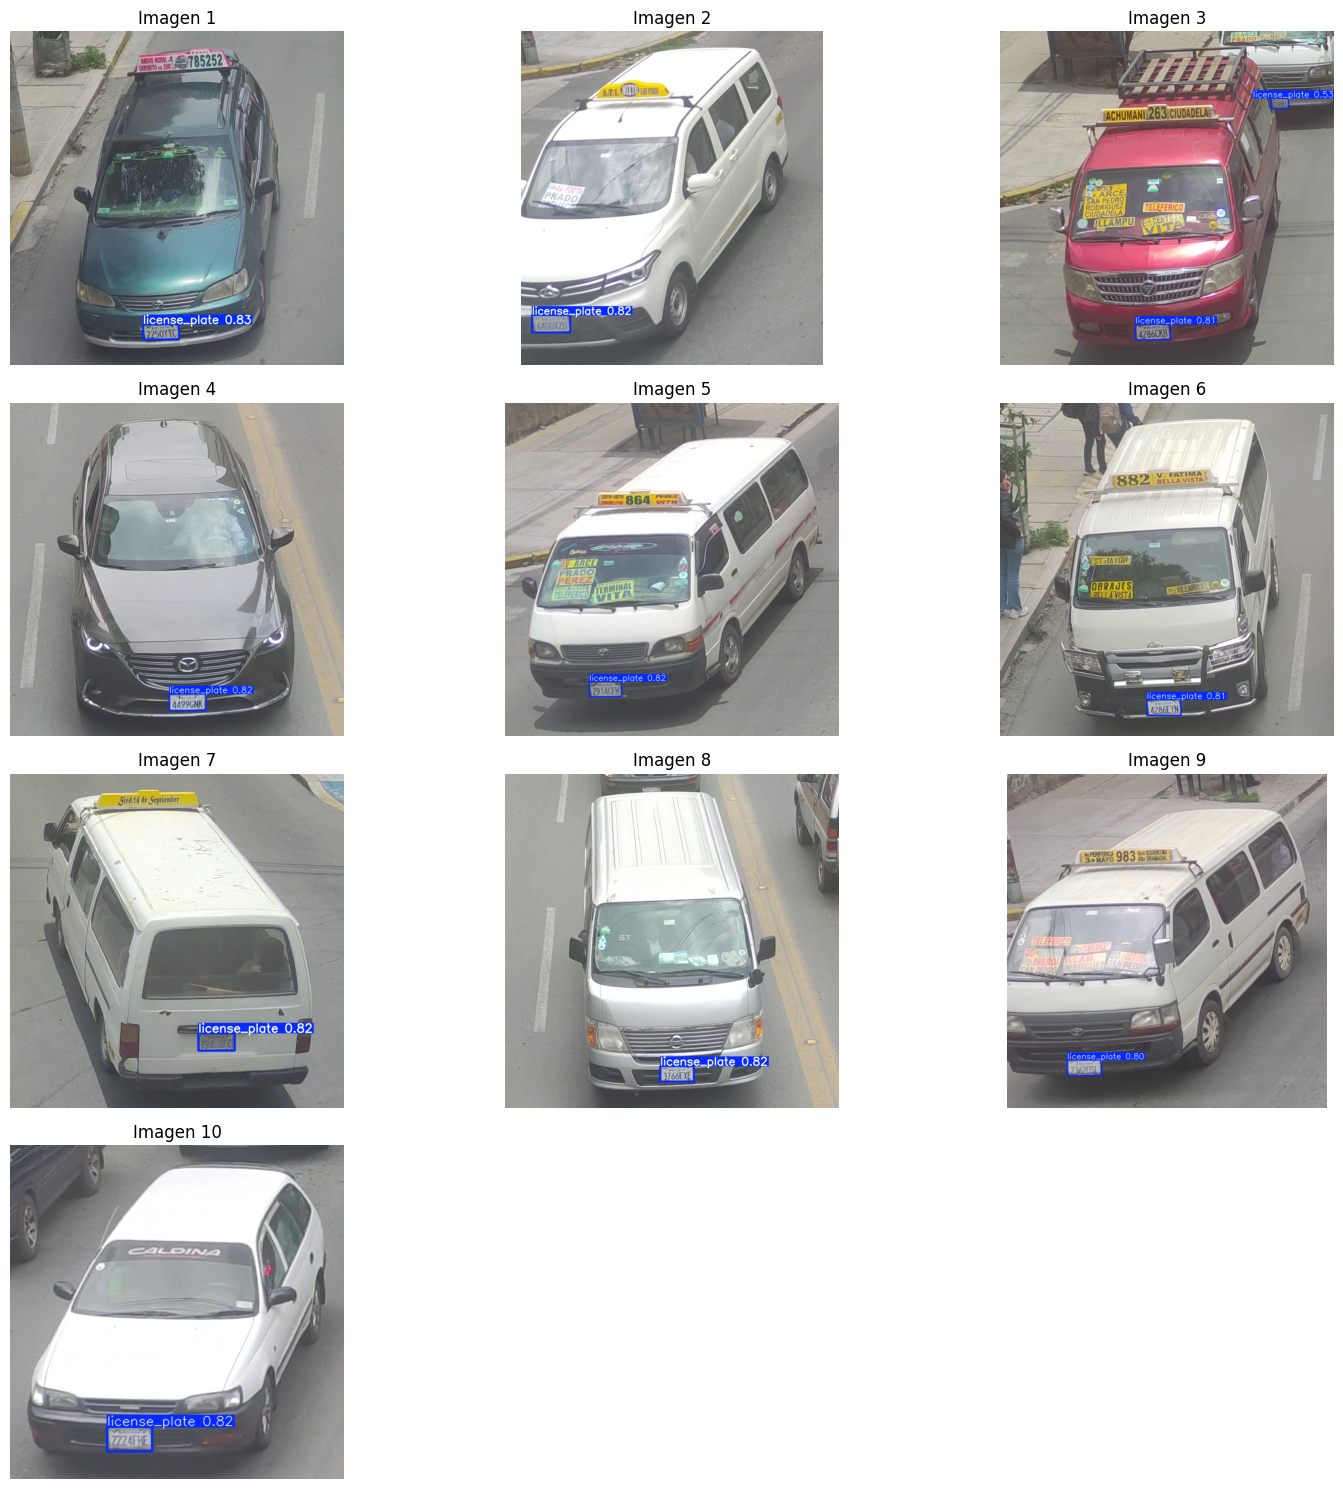

In [7]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import os
import random
%matplotlib inline

# Ruta a tu modelo entrenado
model_path = "runs/detect/YOLOv11_plates2/weights/best.pt"

# Carpeta que contiene las imágenes
image_folder = "yolov11/data_images/validation/images/"

# Cargar el modelo entrenado
model = YOLO(model_path)

# Obtener una lista de todas las imágenes en la carpeta
image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Seleccionar 10 imágenes al azar
random_images = random.sample(image_files, min(10, len(image_files)))

# Crear una lista para almacenar las imágenes anotadas
annotated_images = []

# Procesar cada imagen seleccionada
for image_path in random_images:
    # Leer la imagen original
    original_image = cv2.imread(image_path)
    original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    
    # Realizar la predicción
    results = model.predict(source=image_path, save=False, save_txt=False)
    result = results[0]  # Extraer la primera predicción (si hay varias imágenes)
    
    # Dibujar las predicciones en la imagen
    annotated_image = result.plot()
    annotated_image_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
    
    # Guardar la imagen anotada
    annotated_images.append(annotated_image_rgb)

# Mostrar las imágenes anotadas en un grid
plt.figure(figsize=(15, 15))
for i, img in enumerate(annotated_images):
    plt.subplot(4, 3, i + 1)  # Configurar un grid de 4 filas y 3 columnas
    plt.imshow(img)
    plt.axis("off")  # Ocultar ejes
    plt.title(f"Imagen {i + 1}")

plt.tight_layout()
plt.show()



image 1/1 c:\Users\ALIENWARE M16 R1\Documents\Projects\Python\ANPR\yolov11\data_images\validation\images\car_038.png: 640x640 1 license_plate, 56.2ms
Speed: 3.5ms preprocess, 56.2ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)


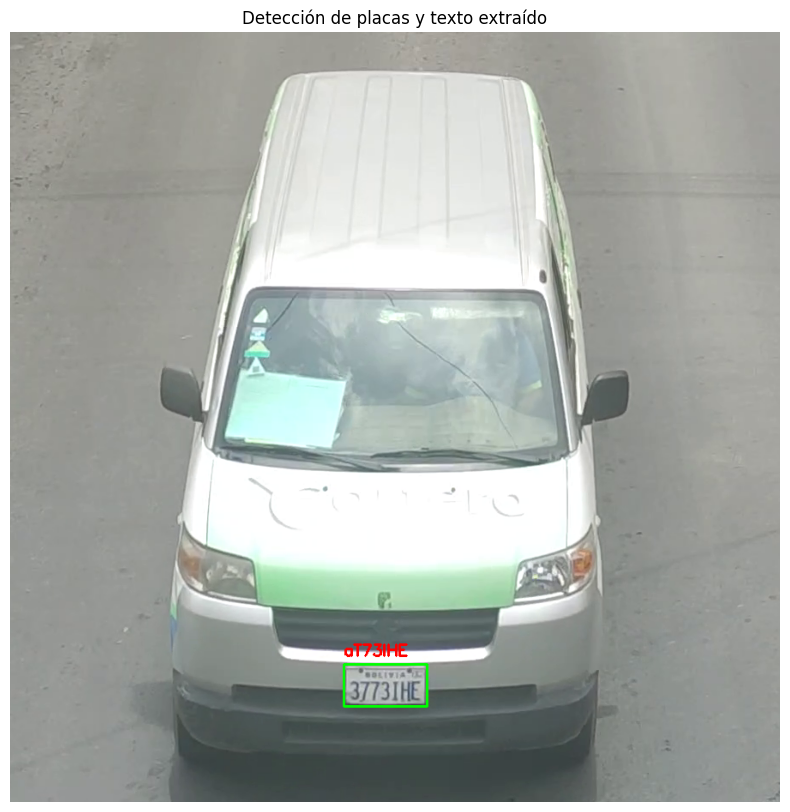

Textos detectados:
Texto: aT73IHE, Confianza: 0.81


In [8]:
from ultralytics import YOLO
import cv2
import pytesseract as pt
import matplotlib.pyplot as plt
%matplotlib inline

# Configurar la ruta de Tesseract OCR
pt.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

# Función para extraer texto de una región de interés (ROI)
def extract_text(image, bbox):
    x1, y1, x2, y2 = map(int, bbox)  # Convertir las coordenadas a enteros
    roi = image[y1:y2, x1:x2]  # Recortar la ROI de la imagen

    if 0 in roi.shape:  # Si el ROI tiene un tamaño inválido
        return 'no number'
    else:
        # Extraer el texto de la ROI utilizando Pytesseract
        text = pt.image_to_string(roi, config='--psm 8')  # PSM 8 para texto en una sola línea
        text = text.strip()  # Limpiar el texto
        return text

# Ruta a tu modelo entrenado
model_path = "runs/detect/YOLOv11_plates2/weights/best.pt"

# Ruta de la imagen de prueba
image_path = "yolov11/data_images/validation/images/car_038.png"

# Cargar el modelo entrenado
model = YOLO(model_path)

# Realizar la predicción
results = model.predict(source=image_path, save=False, save_txt=False)

# Extraer la primera predicción
result = results[0]

# Leer la imagen original (para extraer el ROI)
original_image = cv2.imread(image_path)

# Convertir la imagen a RGB para matplotlib y pytesseract
original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

# Almacenar texto detectado
detected_texts = []

# Iterar sobre las detecciones
for bbox, cls, conf in zip(result.boxes.xyxy, result.boxes.cls, result.boxes.conf):
    if int(cls) == 0:  # Clase 0: Placa (ajustar si las clases cambian)
        # Extraer el texto de la placa
        text = extract_text(original_image_rgb, bbox)
        detected_texts.append((text, conf.item()))
        
        # Dibujar el ROI y el texto en la imagen
        x1, y1, x2, y2 = map(int, bbox)
        cv2.rectangle(original_image_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(original_image_rgb, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

# Mostrar la imagen con predicciones y texto
plt.figure(figsize=(10, 10))
plt.imshow(original_image_rgb)
plt.axis("off")
plt.title("Detección de placas y texto extraído")
plt.show()

# Mostrar los textos detectados en la consola
print("Textos detectados:")
for text, conf in detected_texts:
    print(f"Texto: {text}, Confianza: {conf:.2f}")



image 1/1 c:\Users\ALIENWARE M16 R1\Documents\Projects\Python\ANPR\yolov11\data_images\validation\images\car_871.png: 640x640 1 license_plate, 11.5ms
Speed: 4.5ms preprocess, 11.5ms inference, 96.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\Users\ALIENWARE M16 R1\Documents\Projects\Python\ANPR\yolov11\data_images\validation\images\car_465.png: 640x640 1 license_plate, 11.5ms
Speed: 3.0ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\Users\ALIENWARE M16 R1\Documents\Projects\Python\ANPR\yolov11\data_images\validation\images\car_1365.png: 640x640 1 license_plate, 10.5ms
Speed: 2.5ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\Users\ALIENWARE M16 R1\Documents\Projects\Python\ANPR\yolov11\data_images\validation\images\car_443.png: 640x640 1 license_plate, 11.6ms
Speed: 2.5ms preprocess, 11.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image

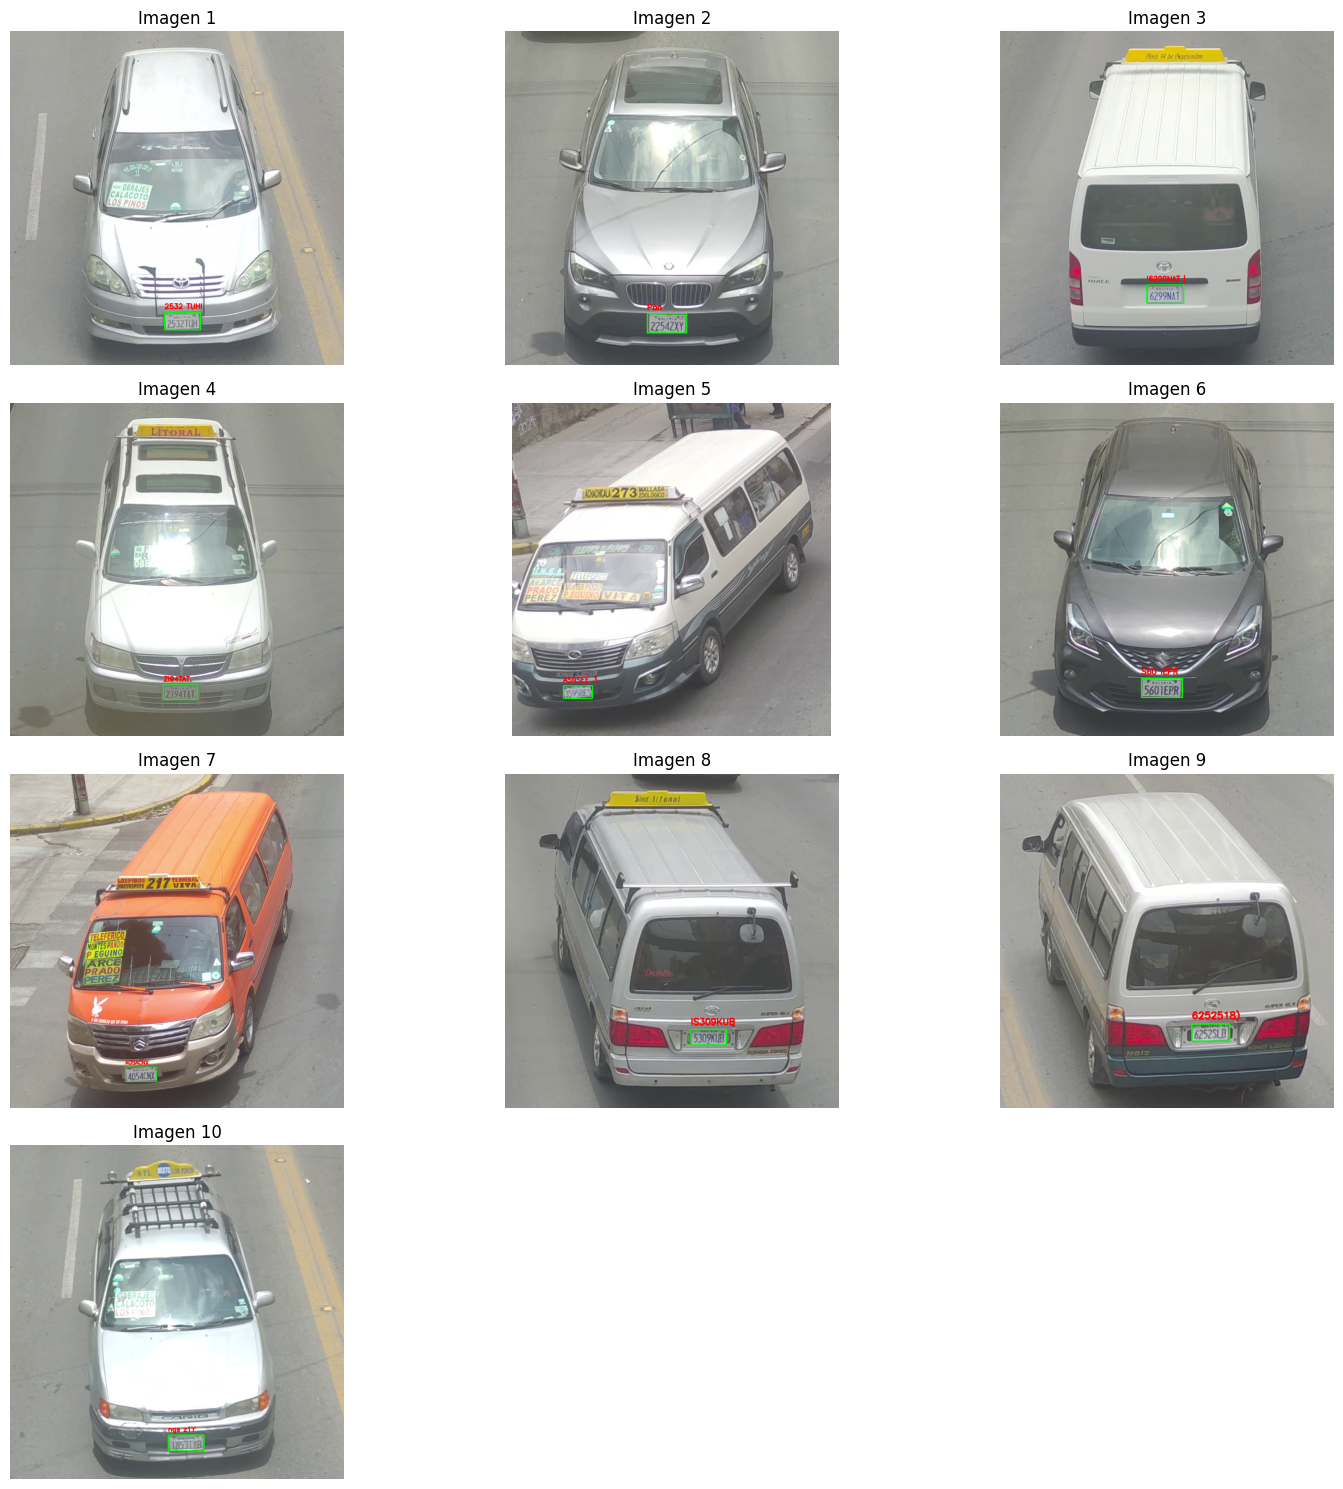

Textos detectados:
Imagen 1:
  Texto: 2532 TUHI, Confianza: 0.80
Imagen 2:
  Texto: Pan, Confianza: 0.82
Imagen 3:
  Texto: '6299NAT |, Confianza: 0.82
Imagen 4:
  Texto: ZI94TAT., Confianza: 0.76
Imagen 5:
  Texto: AS9SEE 3, Confianza: 0.78
Imagen 6:
  Texto: S60 IEPR, Confianza: 0.84
Imagen 7:
  Texto: AQSACNX, Confianza: 0.83
Imagen 8:
  Texto: IS309KUB, Confianza: 0.76
Imagen 9:
  Texto: 6252518), Confianza: 0.78
Imagen 10:
  Texto: ngs z1Y, Confianza: 0.79


In [3]:
from ultralytics import YOLO
import cv2
import pytesseract as pt
import matplotlib.pyplot as plt
import os
import random

# Configurar la ruta de Tesseract OCR
pt.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

# Función para extraer texto de una región de interés (ROI)
def extract_text(image, bbox):
    x1, y1, x2, y2 = map(int, bbox)  # Convertir las coordenadas a enteros
    roi = image[y1:y2, x1:x2]  # Recortar la ROI de la imagen

    if 0 in roi.shape:  # Si el ROI tiene un tamaño inválido
        return 'no number'
    else:
        # Extraer el texto de la ROI utilizando Pytesseract
        text = pt.image_to_string(roi, config='--psm 8')  # PSM 8 para texto en una sola línea
        text = text.strip()  # Limpiar el texto
        return text

# Ruta a tu modelo entrenado
model_path = "runs/detect/YOLOv11_plates2/weights/best.pt"

# Carpeta que contiene las imágenes
image_folder = "yolov11/data_images/validation/images/"

# Cargar el modelo entrenado
model = YOLO(model_path)

# Obtener una lista de todas las imágenes en la carpeta
image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Seleccionar 10 imágenes al azar
random_images = random.sample(image_files, min(10, len(image_files)))

# Crear una lista para almacenar las imágenes anotadas y los textos detectados
annotated_images = []
all_detected_texts = []

# Procesar cada imagen seleccionada
for image_path in random_images:
    # Leer la imagen original
    original_image = cv2.imread(image_path)

    # Convertir la imagen a RGB para matplotlib y pytesseract
    original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    
    # Realizar la predicción
    results = model.predict(source=image_path, save=False, save_txt=False)
    result = results[0]  # Extraer la primera predicción (si hay varias imágenes)
    
    detected_texts = []  # Almacenar textos detectados por imagen
    
    # Iterar sobre las detecciones
    for bbox, cls, conf in zip(result.boxes.xyxy, result.boxes.cls, result.boxes.conf):
        if int(cls) == 0:  # Clase 0: Placa (ajustar si las clases cambian)
            # Extraer el texto de la placa
            text = extract_text(original_image_rgb, bbox)
            detected_texts.append((text, conf.item()))
            
            # Dibujar el ROI y el texto en la imagen
            x1, y1, x2, y2 = map(int, bbox)
            cv2.rectangle(original_image_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(original_image_rgb, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
    
    # Guardar la imagen anotada
    annotated_images.append(original_image_rgb)
    all_detected_texts.append(detected_texts)

# Mostrar las imágenes anotadas en un grid
plt.figure(figsize=(15, 15))
for i, img in enumerate(annotated_images):
    plt.subplot(4, 3, i + 1)  # Configurar un grid de 4 filas y 3 columnas
    plt.imshow(img)
    plt.axis("off")  # Ocultar ejes
    plt.title(f"Imagen {i + 1}")

plt.tight_layout()
plt.show()

# Mostrar los textos detectados en la consola
print("Textos detectados:")
for i, texts in enumerate(all_detected_texts):
    print(f"Imagen {i + 1}:")
    for text, conf in texts:
        print(f"  Texto: {text}, Confianza: {conf:.2f}")
